# House Prices: Advanced Regression Techniques - Part II

In this notebook we continue working with the XGBRegressor.

In [143]:
from load_modules_files_functions_clean import *
print('No. numerical features before feature selection:', len(num_cols))
print('No. ordinal features before feature selection:', len(ord_cols))

No. numerical features before feature selection: 33
No. ordinal features before feature selection: 21


Perform feature selection.

In [144]:
#thresh = 0
thresh = 1

model = joblib.load('model_feature_selection.joblib')
list_features = list(X[num_cols + ord_cols + cat_cols].columns)
model.get_booster().feature_names = list_features

def feature_selector(cols, model, thresh):
    data = model.get_booster().get_score(importance_type = 'weight')
    df = pd.DataFrame.from_dict(data, orient = 'index', columns = ['Feature Importance'])
    features_selected = list(df[df['Feature Importance'] > thresh].index)    
    cols_keep = []
    for col in cols:
        if col in features_selected:
            cols_keep.append(col)
    return cols_keep

num_cols = feature_selector(num_cols, model, thresh)
ord_cols = feature_selector(ord_cols, model, thresh)
print('No. numerical features after feature selection:', len(num_cols))
print('No. ordinal features after feature selection:', len(ord_cols))

No. numerical features after feature selection: 28
No. ordinal features after feature selection: 17


Build the pipeline with ColumnTransformer() for num_cols + ord_cols +cat_cols.

In [145]:
imputer = ColumnTransformer([
    #('imputer_num_ord_cols', SimpleImputer(fill_value = -999), slice(0, len(num_cols + ord_cols))),
    ('imputer_num_ord_cols', 'passthrough', slice(0, len(num_cols + ord_cols))), # Set no imputation
    #('imputer_cat_cols', SimpleImputer(strategy = 'most_frequent'), slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
    ('imputer_cat_cols', 'passthrough' , slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols))) # Set no imputation
])

preprocessor = ColumnTransformer([
            ('scaler_num_cols', 'passthrough', slice(0, len(num_cols))),
            ('scaler_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols)))
            #('category_encoder_cat_cols', None, slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
], remainder = 'drop') # Temporary solution so that the model can be built without cat. features.

xgbr = XGBRegressor(objective = 'reg:squarederror', random_state = 1)

steps = [
    ('imputer', imputer),
    ('preprocessor', preprocessor),         
    ('model', xgbr)
]

pipeline = Pipeline(steps)

#ttr = TransformedTargetRegressor(regressor = pipeline, transformer = None)
ttr = TransformedTargetRegressor(regressor = pipeline, func = np.log1p, inverse_func = np.expm1) # This makes more sense.

Perform hyperparameter tuning of the XGBRegressor()

In [149]:
#Baseline choice of hyp params (no regularization)
#param_grid = [{    
#    'regressor__model__subsample': [0.7],
#    'regressor__model__min_child_weight': [0.5, 0.75, 1, 2, 3, 4 , 5, 6, 7, 8, 9, 10],
#    'regressor__model__max_depth': [None, 1, 2, 3, 4 , 5, 6, 7, 8, 9, 10],
#    'regressor__model__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#    }]

#Best choice of hyp params so far (with regularization)
param_grid = [{
    'regressor__model': [xgbr],
    'regressor__model__max_depth': [1],
    'regressor__model__min_child_weight': [0.5],
    'regressor__model__n_estimators': [600],
    'regressor__model__subsample': [0.7],
    'regressor__model__lambda': [1, 5, 10, 50, 100],
    #'regressor__model__lambda': [5],
    'regressor__model__alpha': [0, 1, 5, 10, 50, 100],
    #'regressor__model__alpha': [0],
    }]

my_s = GridSearchCV(ttr, param_grid = param_grid, cv = 5, scoring = rmsle_scorer, n_jobs = -1, verbose = 10)

In [150]:
my_s = my_s.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   38.2s finished


In [151]:
print_cv_val_score(my_s, print_best_est = False)

Best CV score: 1.339703E-01
Validation score: 1.370741E-01


In [152]:
my_s.best_params_

{'regressor__model': XGBRegressor(alpha=0, base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              lambda=5, learning_rate=None, max_delta_step=None, max_depth=1,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', random_state=1, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.7,
              tree_method=None, validate_parameters=False, verbosity=None),
 'regressor__model__alpha': 0,
 'regressor__model__lambda': 5,
 'regressor__model__max_depth': 1,
 'regressor__model__min_child_weight': 0.5,
 'regressor__model__n_estimators': 600,
 'regressor__model__subsample': 0.7}

In [131]:
model = my_s.best_estimator_.regressor_.named_steps.model

Save the model that will be used for feature selection.

In [61]:
#joblib.dump(model, 'model_feature_selection.joblib')

['model_feature_selection.joblib']

Plot feature importances

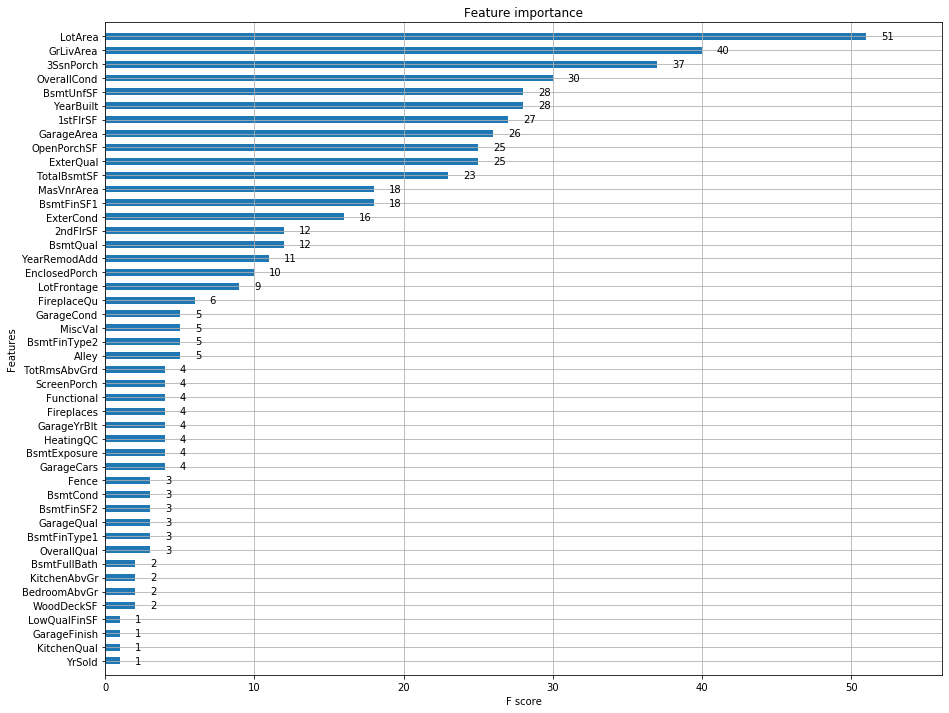

In [132]:
list_features = list(X[num_cols + ord_cols + cat_cols].columns)
del list_features[len(num_cols + ord_cols):] # Remove all cat_cols since they are not used in the model.
model.get_booster().feature_names = list_features
ax = plot_importance(model, height = 0.5) 
fig = ax.figure
fig.set_size_inches(15, 12)

In [ ]:
name = 'xgbr_sub_num_ord_cat.csv'
print(name)
get_sub_csv(my_s, num_cols + ord_cols + cat_cols, name)

## Log

We will follow the advice of JFP.

In the beginning we will not consider the test (LB) score, only validation score.

Complete baseline model (num + ord); drop_cols are considered, no min corr. filter, no log(LotArea), no fillna, no scaling, no HPO ---> CV: 0.1469, Val: 0.1550

Set subsample = 0.7 ---> CV: 0.1508, Val: 0.1525 (better)

Play with min_child_weight (min_child_weight = 9) ---> CV: 0.1442, Val: 0.1571 (worse)
**Note**: Some drop_cols are more important than expected, e.g. LotFrontage and FireplaceQu.

Play with max_depth as well (min_child_weight = 2, max_depth = 2) ---> CV: 0.1370, Val: 0.1422 (better)

Play with n_estimators as well (min_child_weight = 0.5, max_depth = 1, n_estimators = 600) ---> CV: 0.1330, Val: 0.1411 (better)

Since the Val score is below the CV score we add regularization to the model above; lambda (L2) and alpha (L1) (alpha = 0, lambda = 5) ---> CV: 0.1338, Val: 0.1364 (better), Test: 0.14074

Perform feature selection





## Various notes

Use joblib to save a model or pipeline (scikit-learn tip #28)

Four ways to examine the steps of a pipeline (scikit-learn tip #30)

Coluld use ColumnTransformer to do feature engineering (scikit-learn tip #33)

Could use SelectPercentile, chi2 from sklearn.feature_selection (scikit-learn tip #34)